In [ ]:
!pip install hmms --quiet
!pip install pgmpy --quiet
!pip install fredapi --quiet
!pip install myeia --quiet
!pip install tqdm --quiet

In [ ]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

import hmms
import networkx as nx

from pgmpy.estimators import BicScore, K2Score
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fredapi import Fred
api_key = "a98f1a6c0024e4c1e88b4aeac03bd09f"
fred = Fred(api_key)

from myeia.api import API
eia_api_key = "fgAgOxR7HrD3NiIBE9ciYOiAdfWTe82YmiRLZpl1"
eia = API(eia_api_key)

In [ ]:
start_date = "1990-01-01"
end_date = "2024-01-01"

In [ ]:
crude_oil_price = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])
crude_oil_price = crude_oil_price[(crude_oil_price.index >= start_date) & (crude_oil_price.index <= end_date)]
crude_oil_price.index.name = "Date"

In [ ]:
macro_dict = {
    "CPI_energy": "CPIENGSL",
    "CPI_total": "CPIAUCSL",
    "CAP_oil_gas": 'CAPG211S',
    "Util_oil_gas": 'CAPUTLG211S',
    "IP_oil_gas": 'IPG211S',
    "IP_crude_oil": 'IPG211111CN',
    "IP_total": 'INDPRO',
    "IP_drill_oil_gas": 'IPN213111N',
    "PPI_oil": 'PCU211211',
}

macro = pd.DataFrame(fred.get_series("CPIENGSL"), columns=["CPI_energy"]).reset_index().rename(columns={"index": "Date"})
for k, v in macro_dict.items():
  if k == "CPI_energy": continue
  _df = pd.DataFrame(
      fred.get_series(v), columns=[k]
  ).reset_index().rename(columns={"index": "Date"})

  macro = macro.merge(_df, on="Date", how="left")

macro = macro.set_index("Date")
macro = macro[(macro.index >= start_date) & (macro.index <= end_date)]

micro_dict = {
    "crude_oil_inventory_OECD": "PASC_OECD_T3",
    "petroleum_supply_OPEC": "PAPR_OPEC",
    "fuel_consumption_OECD": "PATC_OECD",
    "fuel_consumption_non-OECD": "PATC_NON_OECD",
    "crude_oil_production_US": "COPRPUS",
    "crude_oil_refinery_input": "CORIPUS",
}

micro = eia.get_series_via_route(
    route="steo",
    series=list(micro_dict.values()),
    frequency="monthly",
    facet="seriesId",
    start_date=start_date,
    end_date=end_date
)
micro = micro.sort_values(by='Date')
micro.columns = list(micro_dict.keys())
for col in micro.columns:
    micro[col] = micro[col].astype(float)


df = crude_oil_price
df = df.reset_index().merge(macro.reset_index(), on="Date", how="left").set_index("Date")
df = df.reset_index().merge(micro.reset_index(), on="Date", how="left").set_index("Date")
df["forecast"] = df["WTISPLC"].shift(-1)

In [ ]:
def clear_outliers(df, n_std=3):
    # clip the data outside the lower and upper bounds
    lower_bound = df.mean() - n_std * df.std()
    upper_bound = df.mean() + n_std * df.std()

    df_cleaned = df.clip(lower=lower_bound, upper=upper_bound, axis=1)

    return df_cleaned

def clean_bad_data(df):
    # Remove duplicated rows
    df_cleaned = df[~df.index.duplicated(keep='first')]
    return df_cleaned

def handle_missing_values(df):
    # interpolate the values and drop the rows if the features have no records
    df_cleaned = df.interpolate(method='linear', axis=0)
    df_cleaned = df_cleaned.dropna()
    return df_cleaned

df = clear_outliers(df, 2)
df = clean_bad_data(df)
df = handle_missing_values(df)

In [ ]:
data_size = df.shape[0]

train_data = df[: int(data_size * 0.80)]
val_data = df[int(data_size * 0.80): int(data_size * 0.90)]
test_data = df[int(data_size * 0.90):]

In [ ]:
datasets = df.columns.to_list()

# Regime Detection

In [ ]:
def viterbi(y, A, B, pi):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
    """
    N = B.shape[0]
    x_seq = np.zeros([N, 0])
    V = B[:, y[0]] * pi

    # forward to compute the optimal value function V
    for y_ in y[1:]:
        _V = np.tile(B[:, y_], reps=[N, 1]).T * A.T * np.tile(V, reps=[N, 1])
        x_ind = np.argmax(_V, axis=1)
        x_seq = np.hstack([x_seq, np.c_[x_ind]])
        V = _V[np.arange(N), x_ind]
    x_T = np.argmax(V)

    # backward to fetch optimal sequence
    x_seq_opt, i = np.zeros(x_seq.shape[1]+1), x_seq.shape[1]-1
    prev_ind = x_T
    while i >= 0:
        x_seq_opt[i] = prev_ind
        i -= 1
        prev_ind = x_seq[int(prev_ind), i]
    return x_seq_opt

In [ ]:
dhmm_dict = {}


In [ ]:
price = train_data["WTISPLC"]
price_diff = price.diff()[1:]
e_seq = np.array(price_diff.apply(
    lambda x: 1 if x > 0 else 0).values
)

dhmm_r = hmms.DtHMM.random(3, 2)
e_seq = np.array_split(e_seq, 32)

# Baum-Welch
dhmm_r.baum_welch(e_seq, 100);
dhmm_dict["WTISPLC"] = dhmm_r

s_seq = viterbi(np.concatenate(e_seq), dhmm_r.params[0], dhmm_r.params[1], dhmm_r.params[2])


iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

In [ ]:

for series_id in tqdm(datasets):
  if series_id == "forecast":
    continue
  else:
    dhmm = hmms.DtHMM.random(3, 2)
    data_diff = train_data[series_id].diff()[1:]
    emit_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values)
    emit_seq = np.array_split(emit_seq, 32)
    dhmm.baum_welch(emit_seq, 100);
    dhmm_dict[series_id.replace('.','_')] = dhmm

  0%|          | 0/17 [00:00<?, ?it/s]

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

  6%|▌         | 1/17 [00:08<02:22,  8.91s/it]

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

 12%|█▏        | 2/17 [00:16<01:58,  7.89s/it]

iteration  99 / 100
iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteratio

 18%|█▊        | 3/17 [00:25<02:01,  8.64s/it]

iteration  98 / 100
iteration  99 / 100
iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteratio

 24%|██▎       | 4/17 [00:30<01:32,  7.09s/it]

iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteratio

 29%|██▉       | 5/17 [00:34<01:14,  6.21s/it]

iteration  92 / 100
iteration  93 / 100
iteration  94 / 100
iteration  95 / 100
iteration  96 / 100
iteration  97 / 100
iteration  98 / 100
iteration  99 / 100
iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteratio

 35%|███▌      | 6/17 [00:38<00:59,  5.40s/it]

iteration  96 / 100
iteration  97 / 100
iteration  98 / 100
iteration  99 / 100
iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteratio

 41%|████      | 7/17 [00:42<00:48,  4.86s/it]

iteration  92 / 100
iteration  93 / 100
iteration  94 / 100
iteration  95 / 100
iteration  96 / 100
iteration  97 / 100
iteration  98 / 100
iteration  99 / 100
iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteratio

 47%|████▋     | 8/17 [00:47<00:42,  4.76s/it]

iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteratio

 53%|█████▎    | 9/17 [00:50<00:35,  4.47s/it]

iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteratio

 59%|█████▉    | 10/17 [00:54<00:29,  4.24s/it]

iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteratio

 65%|██████▍   | 11/17 [00:58<00:25,  4.20s/it]

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

 71%|███████   | 12/17 [01:03<00:21,  4.23s/it]

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

 76%|███████▋  | 13/17 [01:06<00:16,  4.08s/it]

iteration  99 / 100
iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteratio

 82%|████████▏ | 14/17 [01:10<00:11,  4.00s/it]

iteration  96 / 100
iteration  97 / 100
iteration  98 / 100
iteration  99 / 100
iteration  100 / 100
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteratio

 88%|████████▊ | 15/17 [01:15<00:08,  4.18s/it]

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

100%|██████████| 17/17 [01:19<00:00,  4.65s/it]

iteration  99 / 100
iteration  100 / 100


In [ ]:
disc_train = pd.DataFrame(index=train_data[1:].index)

for series_id in datasets:
  if series_id == "forecast":
    dhmm = dhmm_dict["WTISPLC"]
  else:
    dhmm = dhmm_dict[series_id.replace('.','_')]
  data_diff = train_data[series_id].diff()[1:]
  emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)
  s_seq = viterbi(emit_seq, dhmm.params[0], dhmm.params[1], dhmm.params[2])
  disc_train[series_id] = s_seq

# Learn Bayesian Network using Hill Climbing

In [ ]:
hc = HillClimbSearch(disc_train)

expert_edges = [
    ("crude_oil_inventory_OECD", "WTISPLC"),
    ("petroleum_supply_OPEC", "WTISPLC"),
    ("fuel_consumption_OECD", "WTISPLC"),
    ("fuel_consumption_non-OECD", "WTISPLC"),
    ]

model = hc.estimate(scoring_method="k2score", fixed_edges=expert_edges)

  0%|          | 0/1000000 [00:00<?, ?it/s]

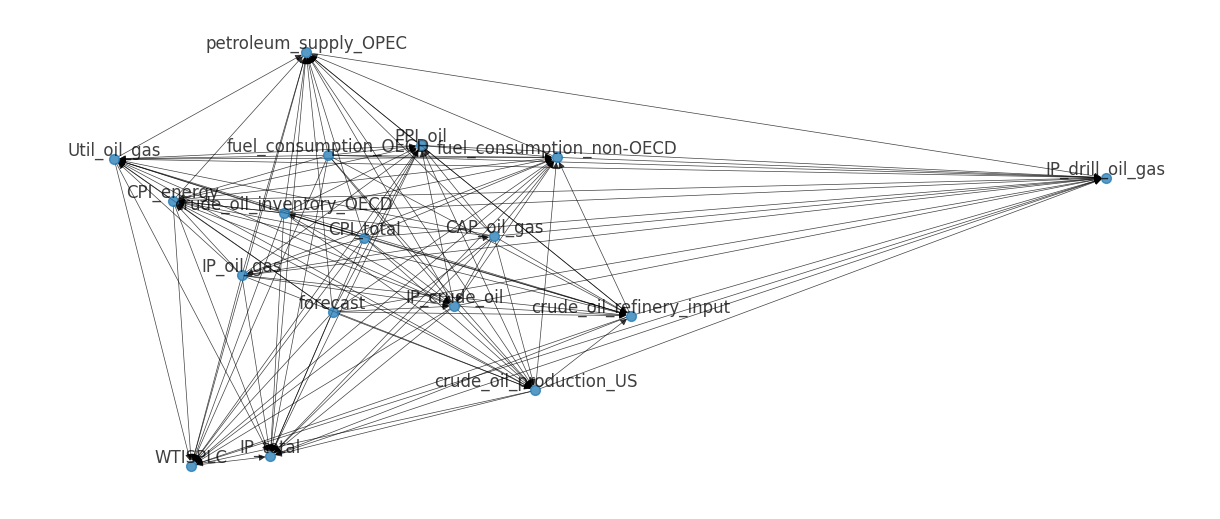

In [ ]:
G = nx.MultiDiGraph()
G.add_edges_from(model.edges())

pos = nx.spring_layout(G)
label_pos = {k: (v[0], v[1] + 0.06) for k, v in pos.items()}

plt.figure(figsize=(12, 5))

nx.draw(G, pos=pos, with_labels = True, node_size=50, alpha = 0.75, width=0.5, arrowstyle='-|>', verticalalignment='bottom')

plt.axis('off')
plt.show()

In [ ]:
edges = list(model.edges())
bs_model = BayesianModel(edges)
bs_model.fit(disc_train, estimator=BayesianEstimator, prior_type='K2')

# Validation

In [ ]:
discrete_val = pd.DataFrame(index = val_data[1:].index)
for series_id in datasets:
  if series_id == "forecast":
    dhmm = dhmm_dict["WTISPLC"]
  else:
    dhmm = dhmm_dict[series_id.replace('.','_')]

  data_diff = val_data[series_id].diff()[1:]

  emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)
  s_seq = viterbi(emit_seq, dhmm.params[0], dhmm.params[1], dhmm.params[2])
  discrete_val[series_id] = s_seq

In [ ]:
states = discrete_val
val_real = states["WTISPLC"]
val_data_new = states.drop("forecast", axis=1)
used_columns = list(set(val_data_new.columns) - (set(val_data_new.columns) - set(bs_model.nodes())))
val_data_new = val_data_new[used_columns]
val_pred = bs_model.predict(val_data_new.astype(int))
pred_value_val = val_pred["forecast"]


In [ ]:

print("Predicted Value:")
print(pred_value_val.values)
print("Real Value:")
print(val_real.values)
error = np.mean(val_real != np.roll(pred_value_val, 1))
print("Error: ", error * 100);

# Test

In [ ]:
discrete_test = pd.DataFrame(index = test_data[1:].index)
for series_id in datasets:
  if series_id == "forecast":
    dhmm = dhmm_dict["WTISPLC"]
  else:
    dhmm = dhmm_dict[series_id.replace('.','_')]

  data_diff = test_data[series_id].diff()[1:]

  emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)
  # emit_seq = np.array_split(emit_seq, 32)

  s_seq = viterbi(emit_seq, dhmm.params[0], dhmm.params[1], dhmm.params[2])
  discrete_test[series_id] = s_seq

In [ ]:
states = discrete_test
test_real = states["WTISPLC"]
test_data_new = states.drop("forecast", axis=1)
used_columns = list(set(test_data_new.columns) - (set(test_data_new.columns) - set(bs_model.nodes())))
test_data_new = test_data_new[used_columns]
test_pred = bs_model.predict(test_data_new.astype(int))
pred_value_test = test_pred["forecast"]

In [ ]:
print("Predicted Value:")
print(pred_value_test.values)
print("Real Value:")
print(test_real.values)
error = np.mean(test_real != np.roll(pred_value_test, 1))
print("Test Error: ", error * 100);